# Eurovision Neighbour Effect
This submission uses data regarding the historical voting patterns of the Eurovision Song Contest(ESC) in order to determine if any statistical basis can be found for the allegation of voting collusion between countries.

The so-called Neighbour Effect is the phenomenon that has long been attributed to the ESC in which neighbouring or culturally-related countries preferentially vote for each others' submissions rather than to any objectively best song.

We will attempt to determine a) collusive relationships between countries, i.e. two countries that vote for each other more often than would be expected statistically, b) net vote recipients, i.e. countries who consistently get voted more than would be expected statistically, c) the way these relationships vary over time.

The dataset we will use was obtained from https://www.kaggle.com/datagraver/eurovision-song-contest-scores-19752017/data and it encompasses all the votes awarded/received by all the participating countries between 1975 and 2017 at both finals and semi-finals.

The process we use will be to conduct a number of simulated contests for each year separately, taking into account the countries participating during that year. Voting for each pair of participating countries is simulated and averaged over a five year period and the 99th percentile vote is taken as a threshold. The real votes obtained from the dataset are also averaged over the same year range and voting patterns over the threshold are taken an statistically significant.

From these statistically significant voting patterns we then extract colluding pairs of countries and vote recipient countries, generating graphs encapsulating these relationships. We optionally save the generated graphs to Neo4j for further analysis.

In [15]:
library(dplyr)
library(Matrix)
library(data.table)
library(igraph)
library(RNeo4j)

Options controlling various aspects of the process.

In [16]:
# Option to extract the vote recipient countries. If this is set to FALSE 
# only colluding pairs of countries will be determined.
extract.one.sided.votes=TRUE

# The number of simulations to conduct over each five year period
# Default: 10000
trials <- 10000

# Save the resulting graphs to Neo4j
write.to.neo4j=FALSE
neo4j.url <- "http://localhost:7474/db/data/"

# The possible votes in the ESC
possible.votes <- c(12, 10, 8, 7, 6, 5, 4, 3, 2, 1)

# The range of years under consideration
year.range.all<-seq(1975,2017)
year.ranges<-list(c(1975,1980), c(1981, 1985), c(1986, 1990), c(1991, 1995), 
                  c(1996, 2000), c(2001, 2005), c(2006, 2010), c(2011, 2015), c(2016, 2017))

In [106]:
getWinners <- function(start.year, end.year){
    return(summarize(group_by(arrange(summarize(group_by(
                voting.history %>% filter(Year>=start.year & Year<=end.year, X.semi...final=="f"), 
                    Year, X.semi...final, To.country), 
                Total=sum(Points)), Year, desc(Total)), Year), 
                winning.country=first(To.country), points=first(Total)))
}

getWinners(1975, 1980)

Year,winning.country,points
1975,The Netherlands,152
1976,United Kingdom,164
1977,France,136
1978,Israel,157
1979,Israel,125
1980,Ireland,143


The _simulate.voting_ function simulates the voting for a given year range for the given number of times returning the 99th percentile thresholds.

Parameters:

**voting.history**: The data from the Eurovision dataset. The function uses this data to determine which countries participated in any given year

**start.year**: the starting year to simulate

**end.year**: the last year to simulate

**iters**: The number of iterations to simulate


In [ ]:
simulate.voting <- function(voting.history, start.year, end.year, iters=10000){
  #year.votes <- voting.history %>% filter(Year==year)
  donor.countries <- unique(voting.history$From.country)
  recip.countries <- unique(voting.history$To.country)
  
  # Precompute voting countries per year
  voting.countries.count <- sapply(X=seq(start.year,end.year), simplify=TRUE, FUN=function(year) {    
    year.votes <- voting.history %>% 
    filter(Year==year)
    voting.countries <- unique(year.votes$From.country)
  
    S<-length(voting.countries)
    
    return(S)
  }) 
  
  voting.countries <- sapply(X=seq(start.year,end.year), simplify=FALSE, FUN=function(year) {    
    year.votes <- voting.history %>% 
      filter(Year==year)
    voting.countries <- unique(as.character(year.votes$From.country))
    
    return(voting.countries)
  }) 
  
  voted.countries <- sapply(X=seq(start.year,end.year), simplify=FALSE, FUN=function(year) {    
    year.votes <- voting.history %>% 
      filter(Year==year)
    voted.countries <- unique(as.character(year.votes$To.country))
    
    return(voted.countries)
  }) 
  simulated.votes.thresh <- data.frame(matrix(data=0, nrow=length(donor.countries), ncol=length(recip.countries)))
  row.names(simulated.votes.thresh) <- donor.countries
  colnames(simulated.votes.thresh) <- recip.countries
  
  for (from.country in donor.countries){
    cat("From ", from.country, "\n")
    for (to.country in recip.countries[recip.countries!=from.country]) {
      if (from.country != to.country)
      {
        #cat("To ", to.country, "\n")
        average_simulation <- vector()
        last.variances <- vector()
        for (iter in 1:iters){
          one_simulation=vector()
          for (year in start.year:end.year) {
            
            if ((from.country %in% voting.countries[[year-start.year+1]]) &&
                (to.country %in% voted.countries[[year-start.year+1]]))
            {
              S<-voting.countries.count[year-start.year+1]
              position <- ceiling(runif(1, 1, S))
              vote <- ifelse(position <= 10, possible.votes[position], 0)
              one_simulation <- c(one_simulation, vote)
            }
          }
          if (length(one_simulation)>0){
            average_simulation<-c(average_simulation, mean(one_simulation))
          }
          # Only test for convergence after at least 50 iterations
          if (length(average_simulation)>50){
            variance <- var(average_simulation)
            if (length(last.variances) < 5) { # check last 5 variances
              last.variances <- c(last.variances, variance)
            }
            else
            {
              last.variances <- c(last.variances[-1], variance)
            }
            
            if (length(last.variances) >= 5){
              varmean <- mean(last.variances)
              maxvar <- max(abs(last.variances-varmean))
              
              if ((maxvar) < 0.001){
                cat("Detected convergence at", iter, "simulations for", 
                    from.country, "->", to.country, "during ", start.year, "-", end.year, ". \n")
                
                break
              }
            }
          }
        }
        thresh <- quantile(average_simulation, probs=c(0.99), names=FALSE)[1]
        if (!is.na(thresh)) {
          simulated.votes.thresh[from.country,to.country] <- thresh
        }
      }
    }
  }
  return(simulated.votes.thresh)
} 

Function _get.average.votes_ extracts the average votes over the given year range from the dataset for each pairwise combination of countries.

Parameters:

**voting.history**: the dataset

**start.year**/**end.year**: the year range over which to average the votes

In [12]:
get.average.votes <- function(voting.history, start.year, end.year){
  donor.countries <- unique(voting.history$From.country)
  recip.countries <- unique(voting.history$To.country)
  
  average.votes <- data.frame(matrix(data=0, nrow=length(donor.countries), ncol=length(recip.countries)))
  row.names(average.votes) <- donor.countries
  colnames(average.votes) <- recip.countries

  year.votes <- voting.history %>% 
    filter(between(Year, start.year, end.year), Duplicate!="x") %>%
    select(From.country, To.country, Points) %>%
    group_by(From.country, To.country) %>% summarise_all(mean)
  
  for (r in 1:nrow(year.votes)){
    fromCountry <- as.character(year.votes$From.country[r])
    toCountry <- as.character(year.votes$To.country[r])
    votes <- as.numeric(year.votes$Points[r])
    average.votes[fromCountry, toCountry] <- votes
  }
  
  return(average.votes)
}

Functon _find.mutual.voters_ finds the statistically significant collusive voting and vote recipient patterns.

Parameters:

**average.votes**: the pairwise voting averaged over the required year range

**statistically.significant**: A boolean matrix with size matching average.votes indicating which averages exceed the thresholds

**year**: The starting year of the range

Returns:

The detected collusive voters and the one-sided voting relationships

In [13]:
find.mutual.voters <- function(average.votes, statistically.significant, year){
  donor.countries = row.names(average.votes)
  recip.countries = colnames(average.votes)
  
  mutual.voters <- data.frame(country.1=character(), country.2=character(), average.vote.fwd=double(), average.vote.bwd=double(), year=integer())
  onesided.voters <- data.frame(country.1=character(), country.2=character(), average.vote=double(), year=integer())
  for (donor in donor.countries){
    for (recip in recip.countries) {
      if (statistically.significant[donor, recip]){
        mutual<-FALSE
        if ( (recip %in% donor.countries) && (donor %in% recip.countries)) {
          if (statistically.significant[recip, donor]) {
              mutual <- TRUE
              mutual.pair <- data.frame(country.1=donor, country.2=recip, average.vote.fwd=average.votes[donor,recip], average.vote.bwd=average.votes[recip,donor], year=year)
              mutual.voters <- rbind(mutual.voters, mutual.pair)
          }
        }
        if (!mutual){
          recip.pair <- data.frame(country.1=donor, country.2=recip, average.vote=average.votes[donor, recip], year=year)
          onesided.voters <- rbind(onesided.voters, recip.pair)
        }
      }
    }
  }
  
  return(list(mutual=mutual.voters, onesided=onesided.voters))
}


The main process.

Running simulation for years  1975  to  1980 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  1975 - 1980  to  threshold_var_1975_1980.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  1975 - 1980  to  thresholds_1pc_1975_1980.csv 
Running simulation for years  1981  to  1985 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  1981 - 1985  to  threshold_var_1981_1985.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  1981 - 1985  to  thresholds_1pc_1981_1985.csv 


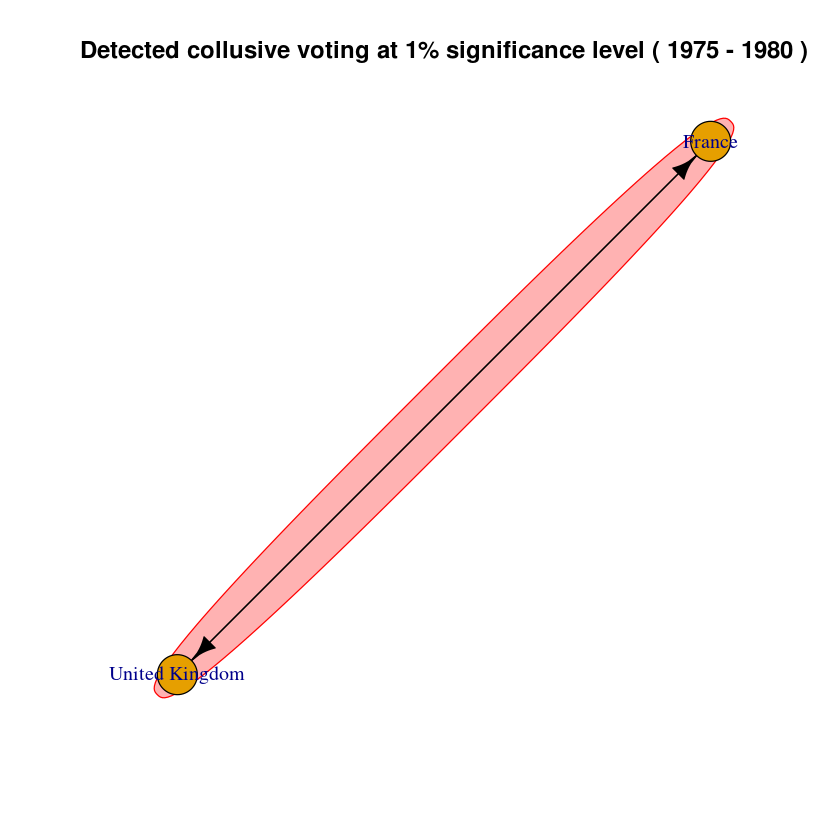

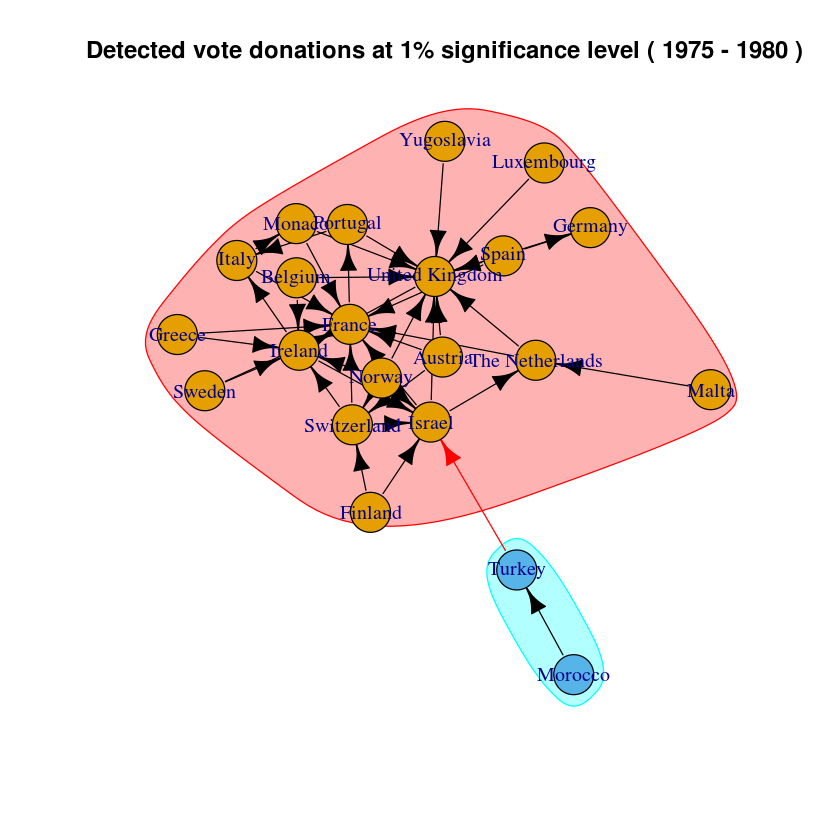

Running simulation for years  1986  to  1990 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  1986 - 1990  to  threshold_var_1986_1990.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  1986 - 1990  to  thresholds_1pc_1986_1990.csv 


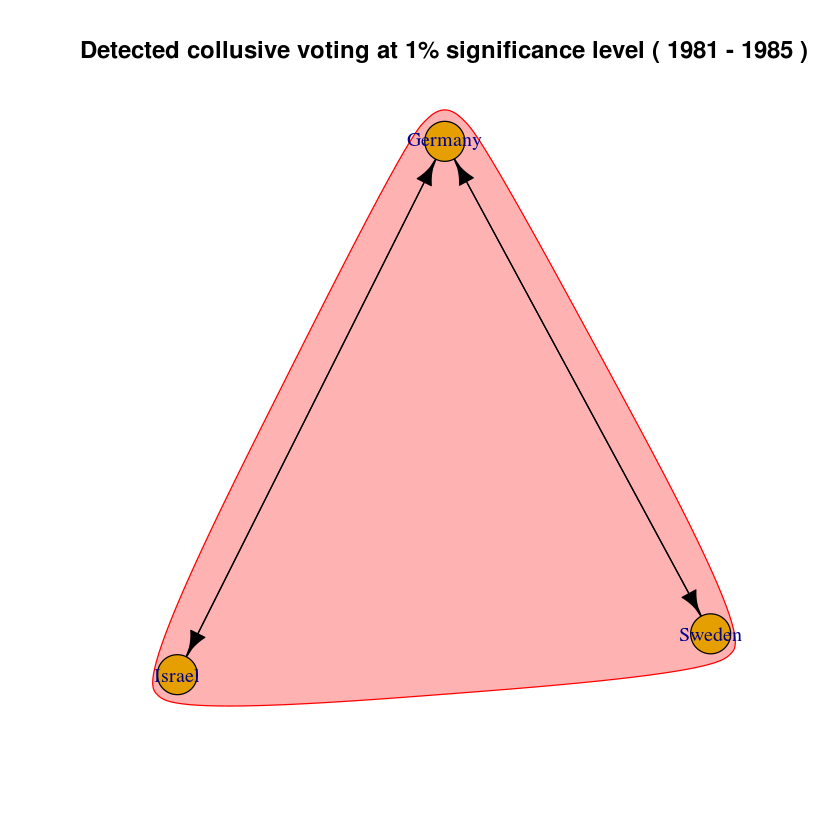

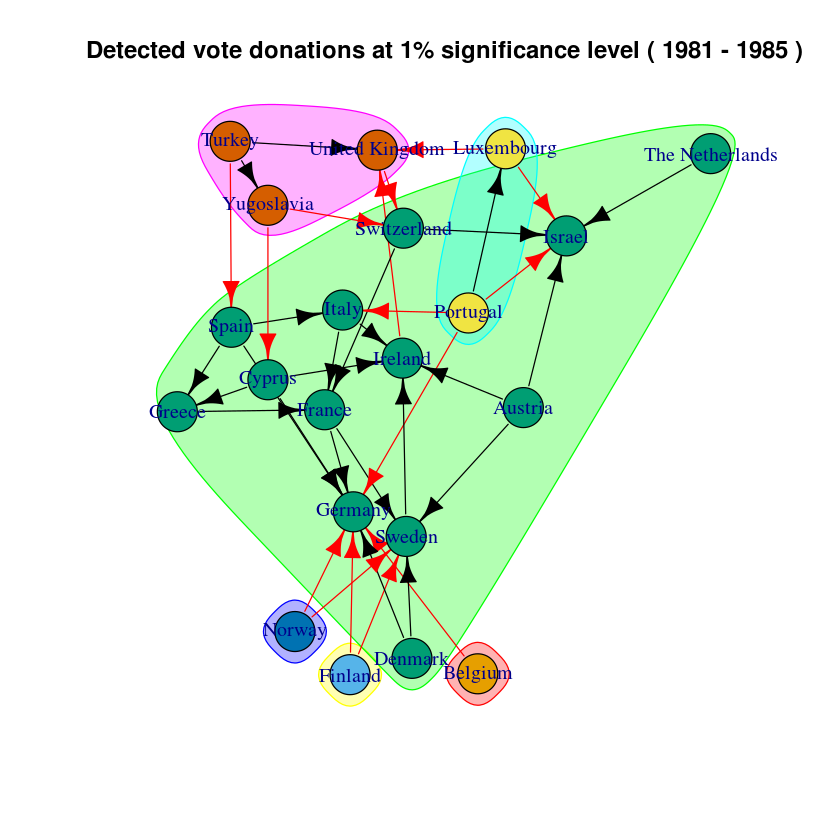

Running simulation for years  1991  to  1995 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  1991 - 1995  to  threshold_var_1991_1995.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  1991 - 1995  to  thresholds_1pc_1991_1995.csv 


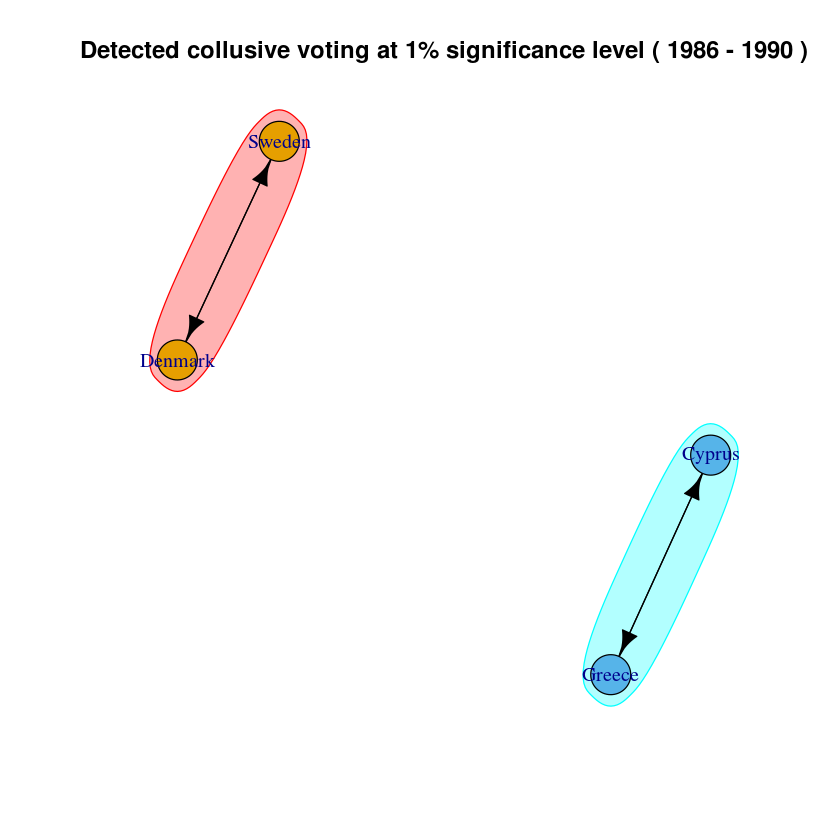

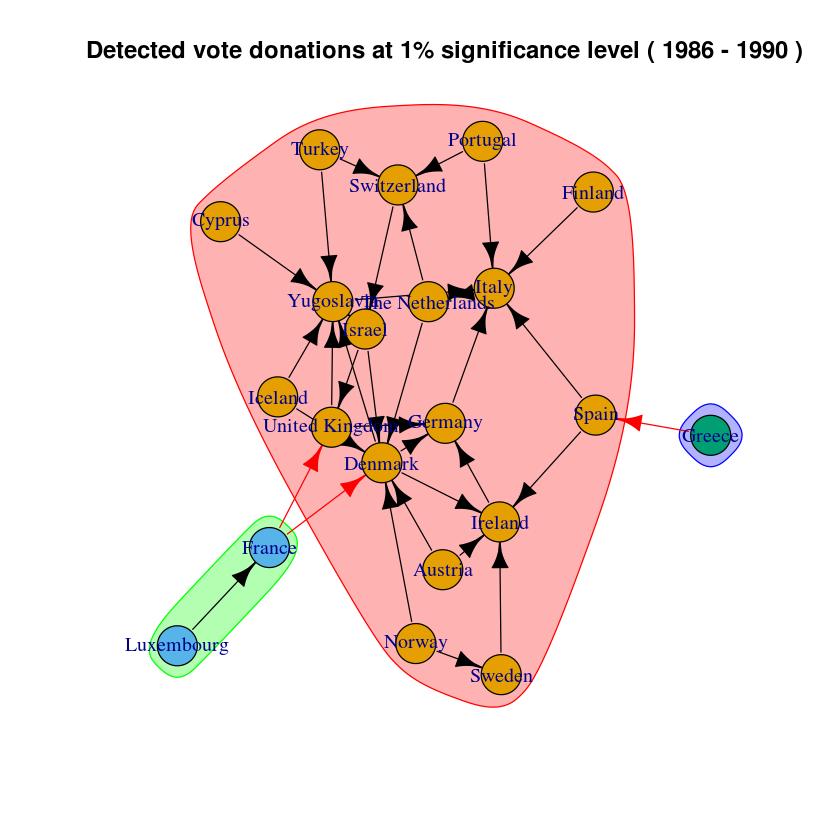

Running simulation for years  1996  to  2000 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  1996 - 2000  to  threshold_var_1996_2000.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  1996 - 2000  to  thresholds_1pc_1996_2000.csv 


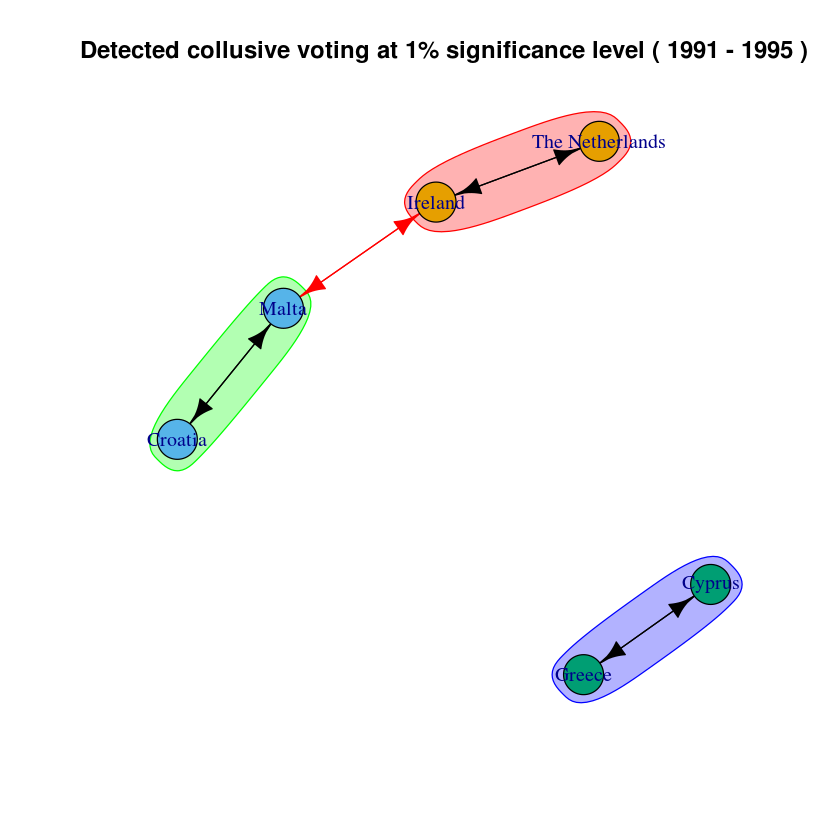

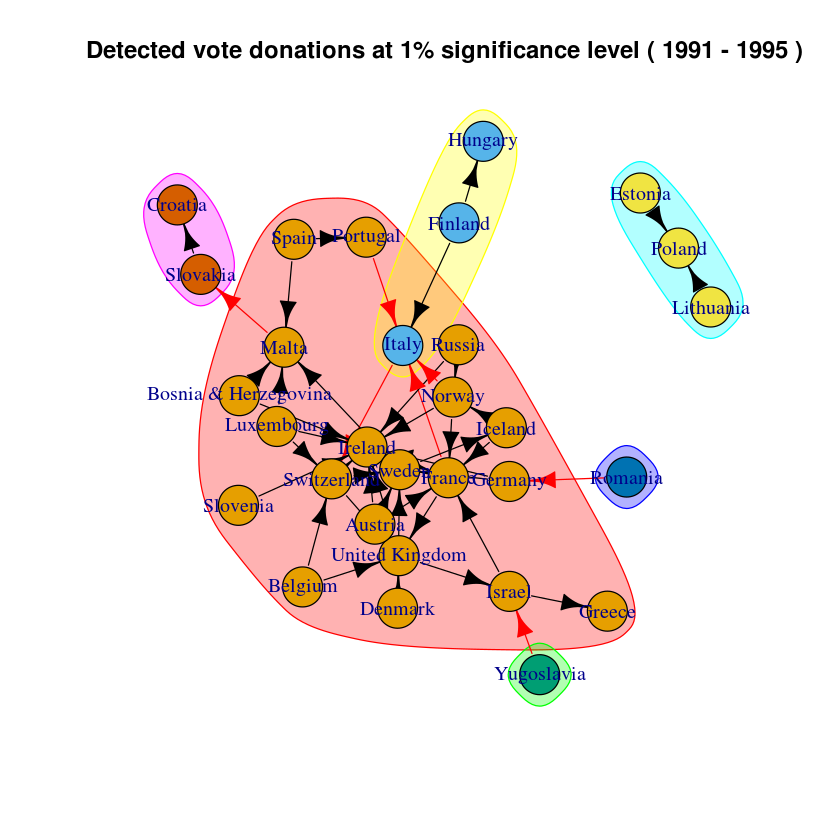

Running simulation for years  2001  to  2005 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  2001 - 2005  to  threshold_var_2001_2005.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  2001 - 2005  to  thresholds_1pc_2001_2005.csv 


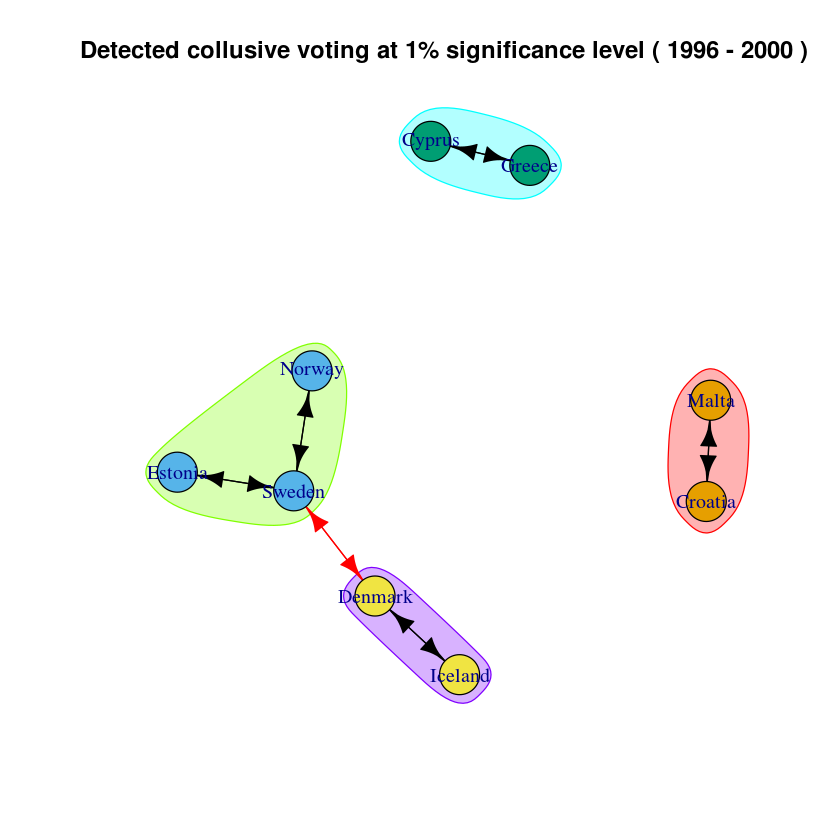

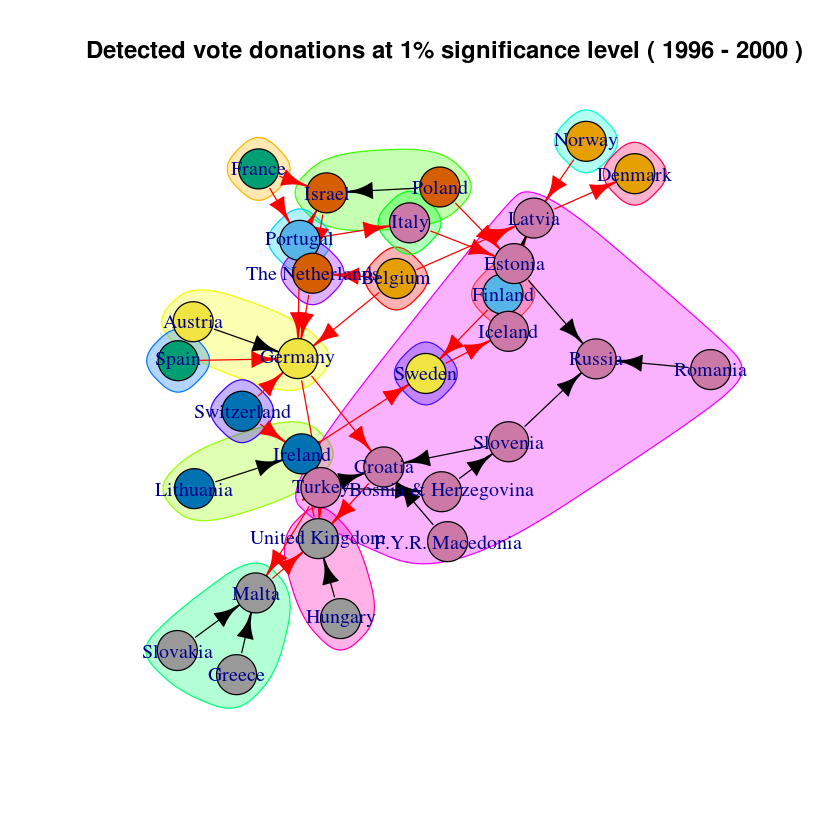

Running simulation for years  2006  to  2010 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  2006 - 2010  to  threshold_var_2006_2010.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  2006 - 2010  to  thresholds_1pc_2006_2010.csv 


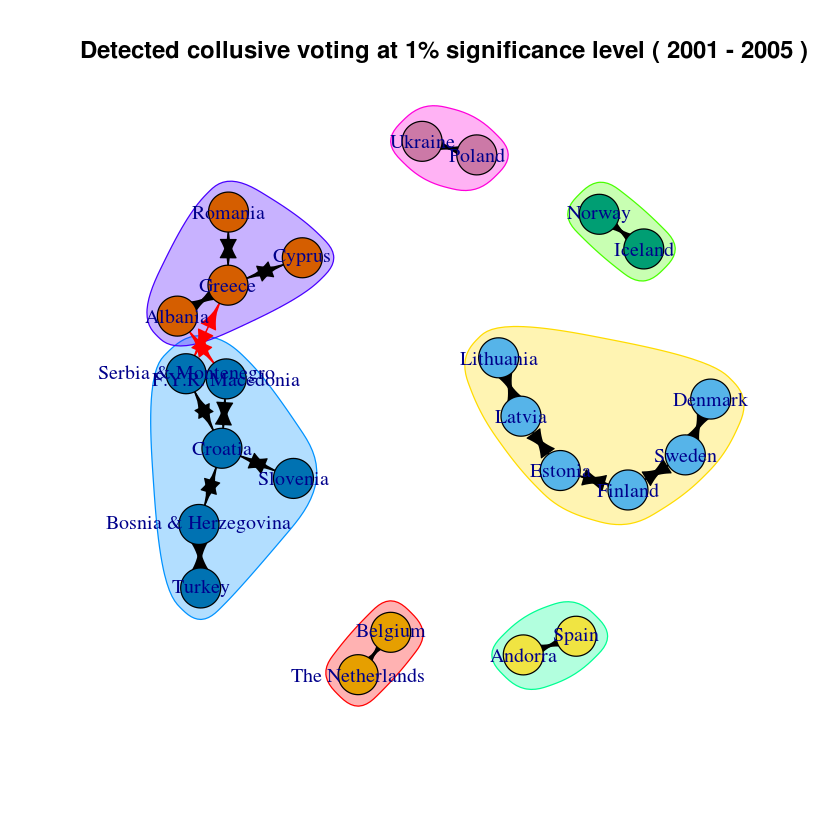

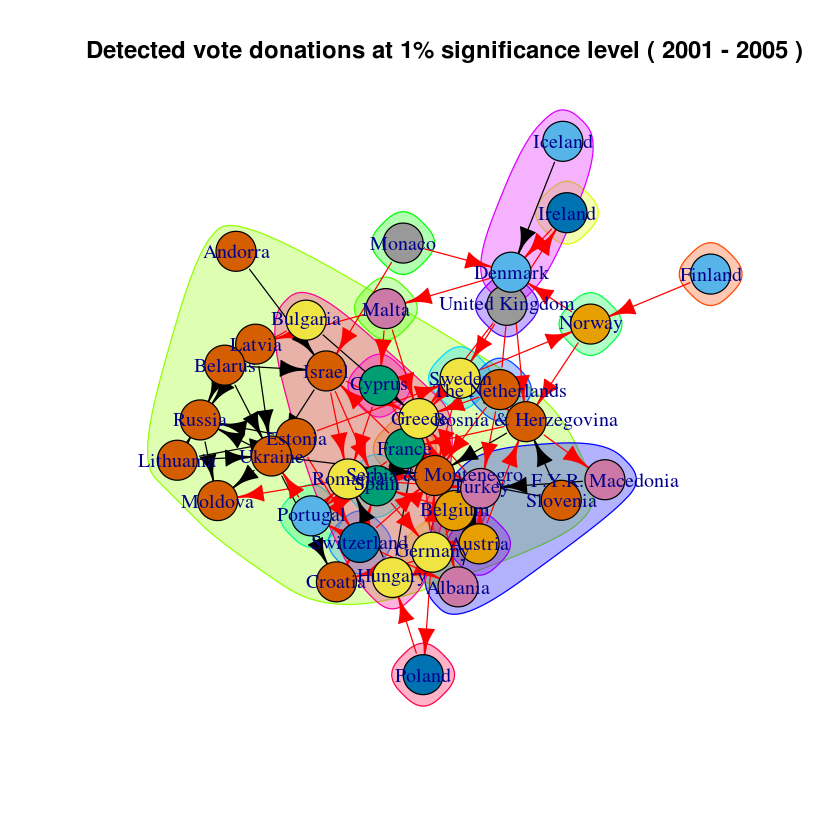

Running simulation for years  2011  to  2015 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  2011 - 2015  to  threshold_var_2011_2015.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  2011 - 2015  to  thresholds_1pc_2011_2015.csv 


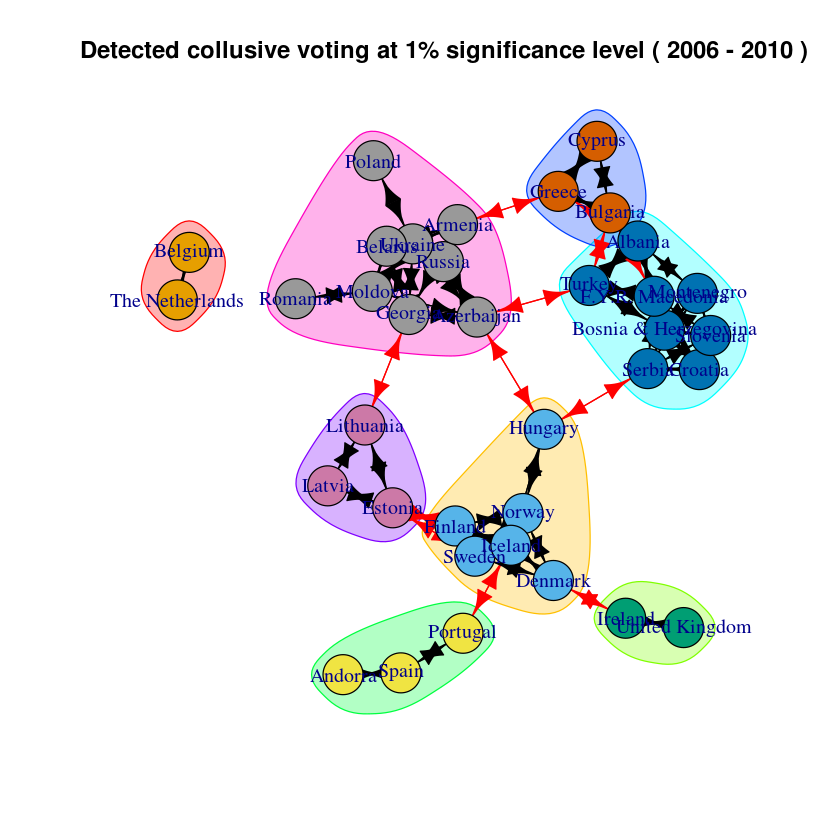

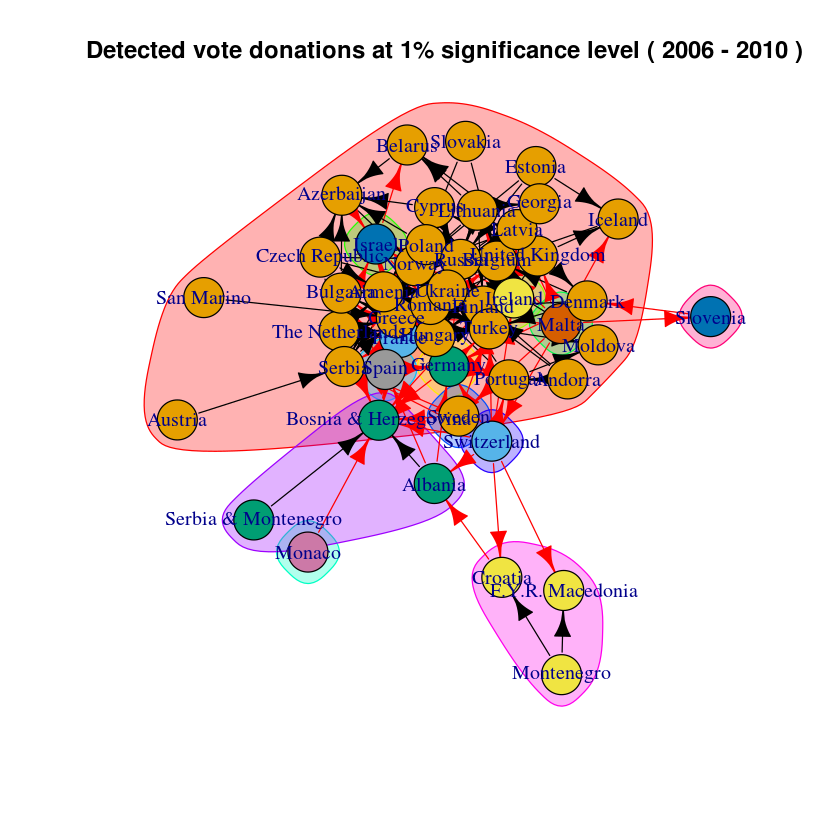

Running simulation for years  2016  to  2017 


Warning message in write.csv(data.frame(variance.matrix), file = var.csv.filename, :
“attempt to set 'col.names' ignored”

Wrote threshold variances for  2016 - 2017  to  threshold_var_2016_2017.csv 


Warning message in write.csv(vote.thresholds, thresh.csv.filename, row.names = TRUE, :
“attempt to set 'col.names' ignored”

Wrote 1% thresholds for  2016 - 2017  to  thresholds_1pc_2016_2017.csv 


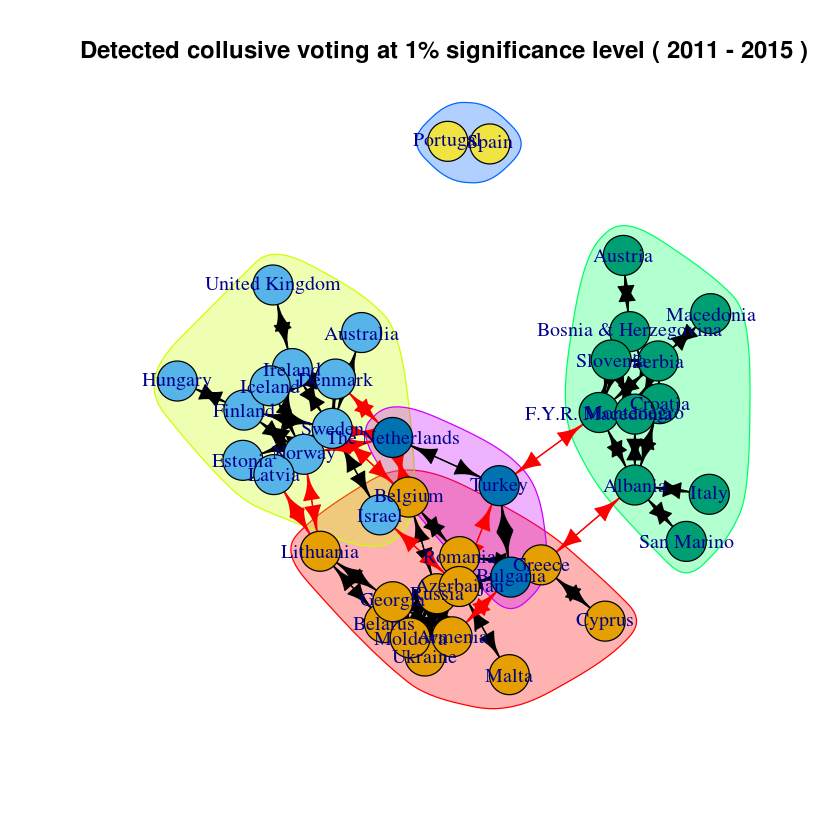

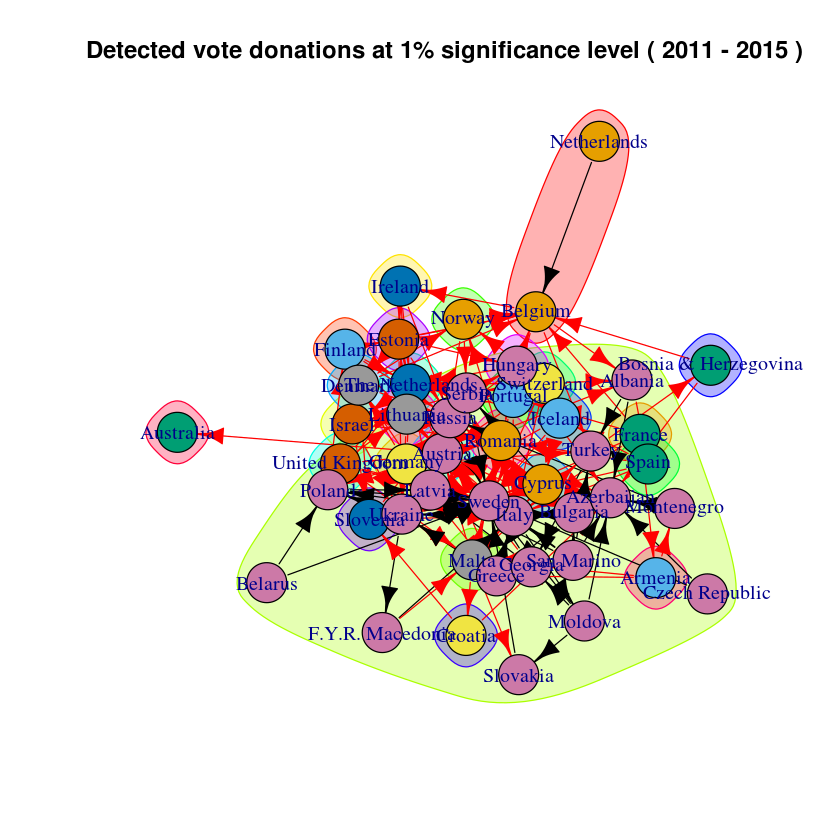

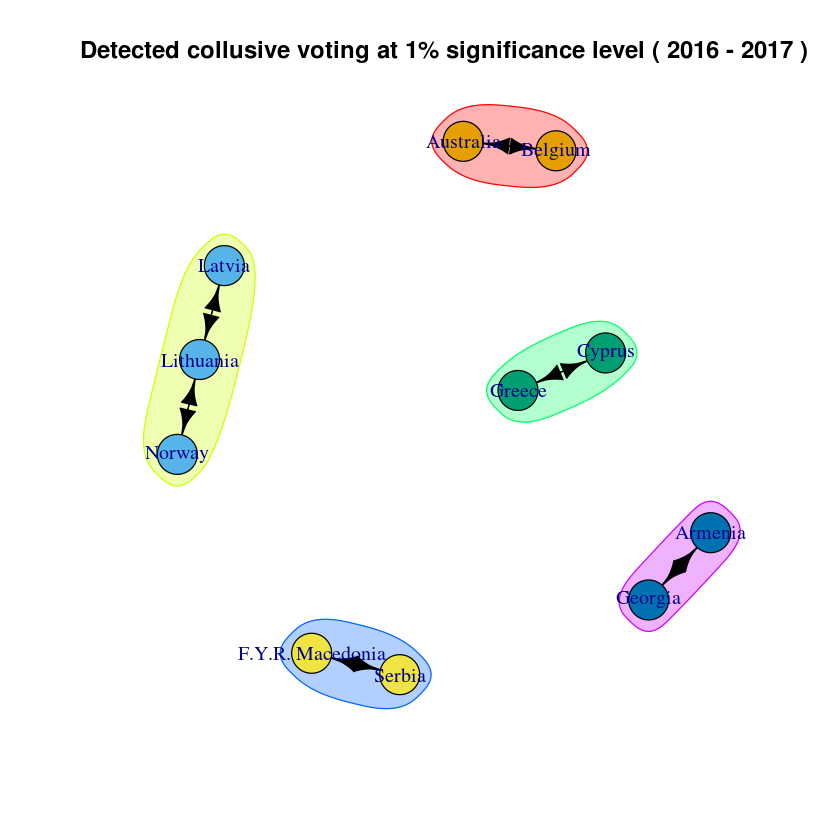

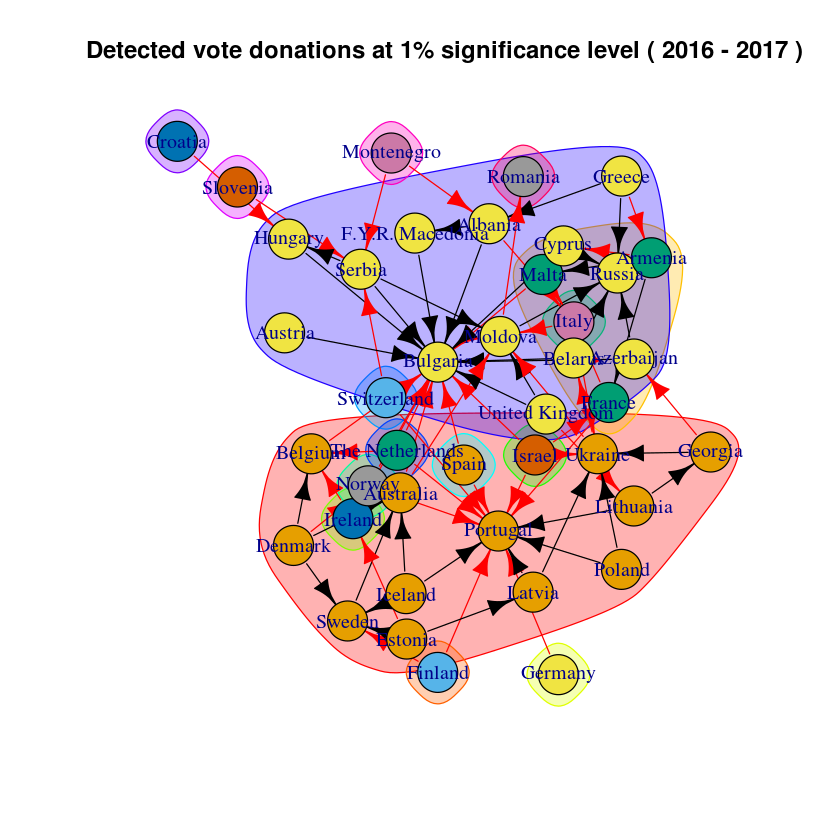

In [17]:
# Load the dataset
voting.history <- read.csv("Data/eurovision_song_contest_1975_2017v4.csv", header = TRUE  )

# Initialise the neo4j database
if (write.to.neo4j) {
  graph = startGraph(neo4j.url)
  clear(graph, input=FALSE)
}

number.collusions <- c()

# Process all the year ranges
for (year.range in year.ranges){
  start.date = year.range[1]
  end.date = year.range[2]
  
  cat("Running simulation for years ", start.date, " to ", end.date, "\n")
  
  average.votes <- get.average.votes(voting.history, start.date, end.date)
  vote.thresholds <- simulate.voting(voting.history, start.date, end.date, trials)
  
    
  # Save the thresholds to file
  thresh.csv.filename <- paste(sep="", "thresholds_1pc_", start.date, "_", end.date, ".csv")
  write.csv(vote.thresholds, thresh.csv.filename, row.names=TRUE, col.names=TRUE)
  cat("Wrote 1% thresholds for ", start.date, "-", end.date, " to ", thresh.csv.filename, "\n")

  # Mask the statistically significant averages depending on the vote thresholds.
  statistically.significant <- average.votes>vote.thresholds
  
  # Find the voting patterns
  significant.votes <- find.mutual.voters(average.votes, statistically.significant, start.date)
  
  number.collusions <- c(number.collusions, nnzero(significant.votes$mutual))
    
  # Generate a graph from the collusive voters...
  ig = graph_from_data_frame(significant.votes$mutual, directed = TRUE)
  ceb <- cluster_edge_betweenness(ig)
  # ... and write it to pdf...

  pdf(file = paste(sep="", "collusions_", as.character(start.date),"_",as.character(end.date),".pdf"))
  plot(ceb, ig, main=paste("Detected collusive voting at 1% significance level (",as.character(start.date),"-",as.character(end.date),")"))
  dev.off()
  # ... as well as to screen.
  plot(ceb, ig, main=paste("Detected collusive voting at 1% significance level (",as.character(start.date),"-",as.character(end.date),")"))

  # If required, also generate graph for one-sided voting patterns.
  if (extract.one.sided.votes){
      ig = graph_from_data_frame(significant.votes$onesided, directed = TRUE)
        
      ceb <- cluster_edge_betweenness(ig)
      
      plot(ceb, ig, main=paste("Detected vote donations at 1% significance level (",as.character(start.date),"-",as.character(end.date),")"))
      pdf(file = paste(sep="", "onesided_", as.character(start.date),"_",as.character(end.date),".pdf"))
      plot(ceb, ig, main=paste("Detected vote donations at 1% significance level (",as.character(start.date),"-",as.character(end.date),")"))

      dev.off()
  }   
    
  # Also write to neo4j if required
  if (write.to.neo4j) {
      countryNodeType <- paste(sep="_", "Country", as.character(start.date))
      addConstraint(graph, countryNodeType, "name")

      addCollusionToGraph <- function(x, graph){
        country1 <- getOrCreateNode(graph, countryNodeType, name=x[1])
        country2 <- getOrCreateNode(graph, countryNodeType, name=x[2])

        createRel(country1, x[3], country2, avgVote=x[3], year=start.date)
        createRel(country2, x[4], country1, avgVote=x[4], year=start.date)
      }

      addDonationToGraph <- function(x, graph){
        country1 <- getOrCreateNode(graph, countryNodeType, name=x[1])
        country2 <- getOrCreateNode(graph, countryNodeType, name=x[2])

        createRel(country1, x[3], country2, avgVote=x[3], year=start.date)
      }
      
      apply(significant.votes$mutual, MARGIN=1, addCollusionToGraph, graph=graph)
      if (extract.one.sided.votes) {
          apply(significant.votes$mutual, MARGIN=1, addDonationToGraph, graph=graph)
      }
  }
}

Generate graph illustrating the number of collusive voting relatinships found with year range.

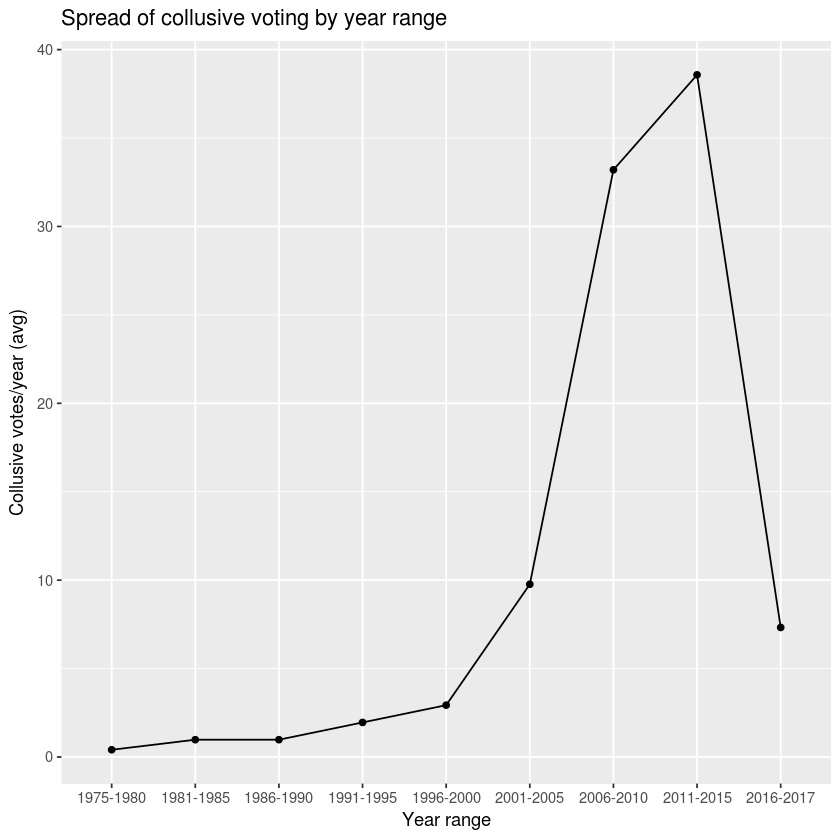

In [78]:
library(ggplot2)

# Div by 2 because number.collusions counts each relationship twice
number.collusions2 <- number.collusions/2

# Divide by number of years in year range
number.collusions2 <- number.collusions2 / sapply(year.ranges, FUN=function(x){return (x[2]-x[1]+1)})
number.collusions2 <- matrix(number.collusions2, nrow=(length(number.collusions2)), ncol=1)
row.names(number.collusions2) <- sapply(year.ranges, FUN=function(x) { return(paste(sep="", x[1],"-", x[2]))})

qplot(row.names(number.collusions2), number.collusions2, geom=c("point", "line"), group=1, main="Spread of collusive voting by year range", ylab="Collusive votes/year (avg)", xlab="Year range")


In [107]:
getWinners(1981, 1985)

Year,winning.country,points
1981,United Kingdom,136
1982,Germany,161
1983,Luxembourg,142
1984,Sweden,145
1985,Norway,123
